<a href="https://colab.research.google.com/github/UjwalNagrikar/Ujwal-BTC_ALGO_TRADE_MODEL/blob/main/Ujwal_BTC_ALGO_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install ccxt
!pip install pybit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 48.3 MB/s eta 0:00:00
  Created wheel for pybit: filename=pybit-5.13.0-py2.py3-none-any.whl size=46161 sha256=489b953d1a5e06fc05fd0fca8f42cb36096ef1698267d2f3a27d936e25bc08bd
  Stored in directory: /root/.cache/pip/wheels/fc/1a/d7/685c4b890f8bd158440312df09b26505fc53b558cfe975addf
Successfully built pybit



🤖 ENHANCED MEXC TRADING BOT - BTC STRATEGY WITH REALISTIC COSTS

📌 FEATURES:
  ✓ MEXC historical data (15m timeframe)
  ✓ Realistic trading costs (fees + slippage)
  ✓ Advanced position sizing & risk management
  ✓ Multiple exit strategies (TP, SL, Trailing, Time-based)

💸 COST SIMULATION:
  • Maker Fee: 0.02%
  • Taker Fee: 0.06%
  • Slippage: 0.10%
  • Stop-loss slippage simulation

📊 VISUALIZATION:
  • Equity curve with profit/loss zones
  • Price action with trade entry/exit markers
  • RSI indicator with overbought/oversold zones
  • MACD with histogram

Enter mode (1=Backtest, 2=Live): 1

🔍 BACKTEST MODE SELECTED

📊 BACKTEST MODE - MEXC DATA WITH REALISTIC COSTS
Initial Capital: $500,000.00
Risk per Trade: 8%
Trading Fees: Maker 0.020% | Taker 0.060%
Slippage: 0.10%

📥 Fetching BTC/USDT:USDT data from MEXC...
   Timeframe: 15m, Limit: 500 candles
✅ Downloaded 500 candles
   Period: 2026-01-01 05:00:00 to 2026-01-06 09:45:00
   Price range: $87,573.10 - $94,674.60

📊 Calculating 

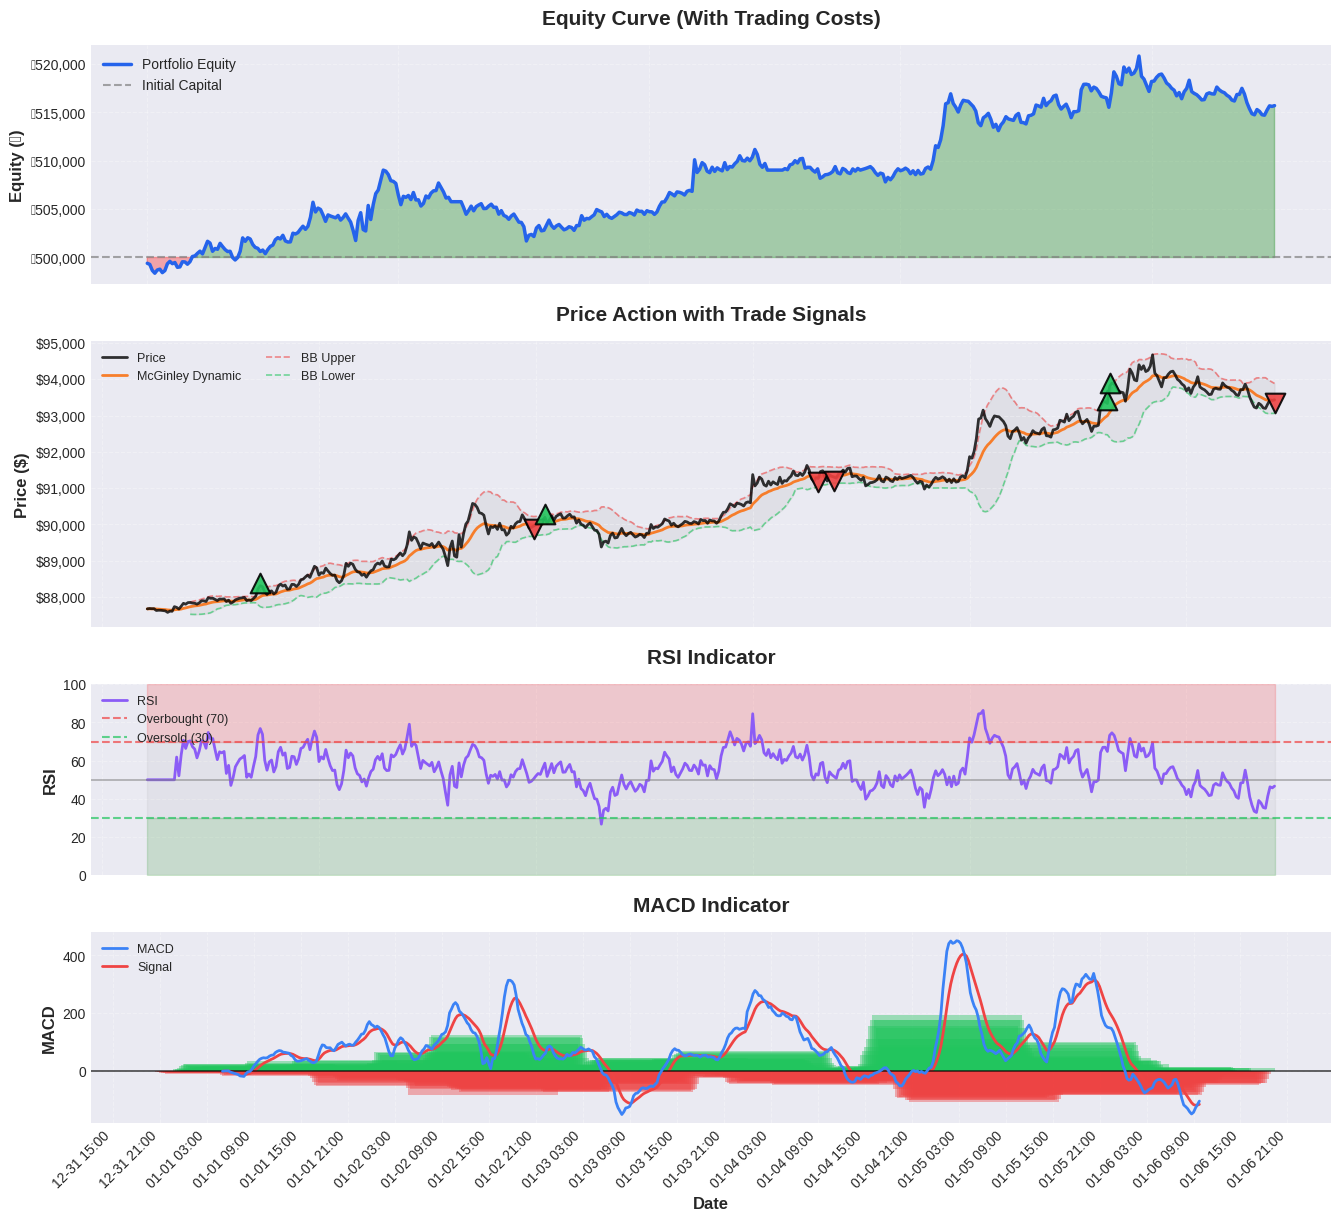

In [10]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import logging
import ccxt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import seaborn as sns

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('mexc_trading_bot.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


class MEXCTradingBot:
    def __init__(self, api_key="", api_secret="", initial_capital=500000, risk_per_trade=0.08):
        """
        Enhanced trading bot with comprehensive visualization and realistic costs

        Args:
            api_key: MEXC API key
            api_secret: MEXC API secret
            initial_capital: Starting capital (₹500,000)
            risk_per_trade: Risk per trade (8%)
        """
        self.api_key = api_key
        self.api_secret = api_secret
        self.initial_capital = initial_capital
        self.risk_per_trade = risk_per_trade
        self.capital = initial_capital
        self.position = None
        self.trades = []
        self.equity_curve = []
        self.is_running = False
        self.client = None

        # Trading costs
        self.maker_fee = 0.0002  # 0.02%
        self.taker_fee = 0.0006  # 0.06%
        self.slippage_pct = 0.0010  # 0.10%
        self.total_fees_paid = 0
        self.total_slippage_cost = 0

    def connect_mexc(self):
        """Connect to MEXC exchange"""
        try:
            self.client = ccxt.mexc({
                'apiKey': self.api_key,
                'secret': self.api_secret,
                'enableRateLimit': True,
                'options': {'defaultType': 'swap'}
            })

            logger.info("✅ Connected to MEXC")
            balance = self.get_balance()
            logger.info(f"💰 Account Balance: ${balance:,.2f} USDT")
            return True

        except Exception as e:
            logger.error(f"❌ Connection failed: {e}")
            return False

    def get_balance(self):
        """Get USDT balance"""
        try:
            balance = self.client.fetch_balance()
            if 'USDT' in balance['free']:
                return float(balance['free']['USDT'])
            return 0
        except Exception as e:
            logger.error(f"Error getting balance: {e}")
            return 0

    def get_historical_data(self, symbol='BTC/USDT:USDT', timeframe='15m', limit=500):
        """Get historical data from MEXC"""
        try:
            print(f"📥 Fetching {symbol} data from MEXC...")
            print(f"   Timeframe: {timeframe}, Limit: {limit} candles")

            ohlcv = self.client.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)

            if not ohlcv:
                print("❌ No data received from MEXC")
                return None

            df = pd.DataFrame(ohlcv, columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)

            for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
                df[col] = df[col].astype(float)

            print(f"✅ Downloaded {len(df)} candles")
            print(f"   Period: {df.index[0]} to {df.index[-1]}")
            print(f"   Price range: ${df['Close'].min():,.2f} - ${df['Close'].max():,.2f}\n")

            return df

        except Exception as e:
            logger.error(f"Error getting data: {e}")
            return None

    # ==================== STRATEGY METHODS ====================

    def calculate_mcginley_dynamic(self, prices, period=14, constant=0.6):
        """McGinley Dynamic calculation"""
        md = pd.Series(index=prices.index, dtype=float)
        md.iloc[0] = prices.iloc[0]

        for i in range(1, len(prices)):
            prev_md = md.iloc[i-1]
            price = prices.iloc[i]

            if prev_md == 0 or pd.isna(prev_md):
                md.iloc[i] = price
                continue

            ratio = max(0.5, min(price / prev_md, 2.0))
            n = max(period * (ratio ** 4) * constant, 1.0)
            md.iloc[i] = prev_md + (price - prev_md) / n

        return md

    def calculate_rsi(self, prices, period=14):
        """RSI calculation"""
        delta = prices.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi.fillna(50)

    def calculate_macd(self, prices, fast=12, slow=26, signal=9):
        """MACD calculation"""
        ema_fast = prices.ewm(span=fast, adjust=False).mean()
        ema_slow = prices.ewm(span=slow, adjust=False).mean()
        macd_line = ema_fast - ema_slow
        signal_line = macd_line.ewm(span=signal, adjust=False).mean()
        histogram = macd_line - signal_line
        return macd_line, signal_line, histogram

    def calculate_atr(self, high, low, close, period=14):
        """ATR calculation"""
        high_low = high - low
        high_close = np.abs(high - close.shift())
        low_close = np.abs(low - close.shift())

        ranges = pd.concat([high_low, high_close, low_close], axis=1)
        true_range = ranges.max(axis=1)
        atr = true_range.ewm(span=period, adjust=False).mean()
        return atr

    def calculate_bollinger_bands(self, prices, period=20, std_dev=2):
        """Bollinger Bands calculation"""
        sma = prices.rolling(window=period).mean()
        std = prices.rolling(window=period).std()
        upper_band = sma + (std * std_dev)
        lower_band = sma - (std * std_dev)
        return upper_band, sma, lower_band

    def calculate_trend_strength(self, close, md, period=20):
        """Trend strength calculation"""
        price_above_md = (close > md).astype(int)
        trend_strength = price_above_md.rolling(window=period).mean()
        return trend_strength

    def calculate_momentum(self, prices, period=10):
        """Momentum calculation"""
        momentum = prices.diff(period) / prices.shift(period) * 100
        return momentum

    def is_liquid_hour(self, timestamp):
        """Liquidity check (trading during most liquid hours)"""
        hour = timestamp.hour
        return 0 <= hour <= 23  # Trade 24/7 for crypto

    def check_long_signal(self, i, close, md, rsi, macd_hist, macd_line,
                         trend_strength, bb_upper, bb_lower, momentum):
        """Long signal logic"""
        if i < 3:
            return False

        price_above_md = close.iloc[i] > md.iloc[i]
        price_cross = (close.iloc[i-1] <= md.iloc[i-1] and close.iloc[i] > md.iloc[i])
        price_signal = price_cross or (price_above_md and close.iloc[i] > close.iloc[i-1])

        rsi_valid = 45 < rsi.iloc[i] < 80

        macd_cross = (macd_hist.iloc[i] > 0 and macd_hist.iloc[i-1] <= 0)
        macd_positive = macd_hist.iloc[i] > 0 and macd_line.iloc[i] > macd_line.iloc[i-1]
        macd_signal = macd_cross or macd_positive

        not_extreme = rsi.iloc[i] < 78
        has_momentum = close.iloc[i] > close.iloc[i-2] or momentum.iloc[i] > -1
        trend_ok = (trend_strength.iloc[i] > 0.3 if not pd.isna(trend_strength.iloc[i]) else True)

        core_signals = price_signal and rsi_valid and macd_signal
        confirmations = not_extreme and has_momentum and trend_ok

        return core_signals and confirmations

    def check_short_signal(self, i, close, md, rsi, macd_hist, macd_line,
                          trend_strength, bb_upper, bb_lower, momentum):
        """Short signal logic"""
        if i < 3:
            return False

        price_below_md = close.iloc[i] < md.iloc[i]
        price_cross = (close.iloc[i-1] >= md.iloc[i-1] and close.iloc[i] < md.iloc[i])
        price_signal = price_cross or (price_below_md and close.iloc[i] < close.iloc[i-1])

        rsi_valid = 20 < rsi.iloc[i] < 55

        macd_cross = (macd_hist.iloc[i] < 0 and macd_hist.iloc[i-1] >= 0)
        macd_negative = macd_hist.iloc[i] < 0 and macd_line.iloc[i] < macd_line.iloc[i-1]
        macd_signal = macd_cross or macd_negative

        not_extreme = rsi.iloc[i] > 22
        has_momentum = close.iloc[i] < close.iloc[i-2] or momentum.iloc[i] < 1
        trend_ok = (trend_strength.iloc[i] < 0.7 if not pd.isna(trend_strength.iloc[i]) else True)

        core_signals = price_signal and rsi_valid and macd_signal
        confirmations = not_extreme and has_momentum and trend_ok

        return core_signals and confirmations

    def calculate_position_size(self, price, atr):
        """Position sizing logic"""
        balance = self.capital
        risk_amount = balance * self.risk_per_trade
        stop_loss_pct = 0.08
        position_size = risk_amount / (price * stop_loss_pct)

        if not np.isnan(atr):
            atr_pct = (atr / price) * 100

            if atr_pct > 3.5:
                position_size *= 0.5
            elif atr_pct > 2.5:
                position_size *= 0.65
            elif atr_pct > 1.5:
                position_size *= 0.8

        max_position = (balance * 0.75) / price
        position_size = min(position_size, max_position)

        min_position = (balance * 0.05) / price
        position_size = max(position_size, min_position)

        position_size = round(position_size, 4)

        return position_size

    def calculate_dynamic_stops(self, entry_price, atr):
        """Stop loss and take profit calculation"""
        tp_pct = 0.12

        if pd.isna(atr):
            sl_pct = 0.10
        else:
            atr_distance = atr / entry_price
            if atr_distance > 0.03:
                sl_pct = 0.12
            elif atr_distance > 0.02:
                sl_pct = 0.11
            else:
                sl_pct = 0.10

        return sl_pct, tp_pct

    def apply_slippage(self, price, side):
        """
        Apply realistic slippage based on market orders

        Args:
            price: Original price
            side: 'buy' or 'sell'

        Returns:
            Adjusted price with slippage
        """
        if side == 'buy':
            # Buying pushes price up
            slipped_price = price * (1 + self.slippage_pct)
        else:
            # Selling pushes price down
            slipped_price = price * (1 - self.slippage_pct)

        return slipped_price

    def calculate_trading_fee(self, position_value, is_maker=False):
        """
        Calculate trading fee

        Args:
            position_value: Total position value
            is_maker: True if maker order, False if taker

        Returns:
            Fee amount
        """
        fee_rate = self.maker_fee if is_maker else self.taker_fee
        fee = position_value * fee_rate
        return fee

    # ==================== BACKTEST METHODS ====================

    def execute_entry_backtest(self, i, close, timestamp, signal_type, position_size, atr):
        """Execute backtest entry with realistic costs"""
        entry_price = close.iloc[i]

        # Apply slippage
        if signal_type == 'LONG':
            real_entry_price = self.apply_slippage(entry_price, 'buy')
        else:
            real_entry_price = self.apply_slippage(entry_price, 'sell')

        position_value = position_size * real_entry_price

        # Calculate entry fee (assume taker order for entries)
        entry_fee = self.calculate_trading_fee(position_value, is_maker=False)

        # Track costs
        slippage_cost = abs(real_entry_price - entry_price) * position_size
        self.total_slippage_cost += slippage_cost
        self.total_fees_paid += entry_fee

        # Deduct costs from capital
        total_cost = position_value + entry_fee

        if total_cost <= self.capital * 0.95:
            sl_pct, tp_pct = self.calculate_dynamic_stops(real_entry_price, atr)

            if signal_type == 'LONG':
                stop_loss = real_entry_price * (1 - sl_pct)
                take_profit = real_entry_price * (1 + tp_pct)
            else:
                stop_loss = real_entry_price * (1 + sl_pct)
                take_profit = real_entry_price * (1 - tp_pct)

            self.position = {
                'type': signal_type,
                'entry': real_entry_price,
                'entry_time': timestamp,
                'entry_bar': i,
                'quantity': position_size,
                'original_quantity': position_size,
                'entry_fee': entry_fee,
                'slippage_cost': slippage_cost,
                'partial_exited': False,
                'trailing_active': False,
                'stop_loss': stop_loss,
                'take_profit': take_profit,
                'sl_pct': sl_pct,
                'tp_pct': tp_pct
            }

            self.capital -= total_cost

            print(f"\n🔔 {signal_type} Entry @ ${real_entry_price:.2f}")
            print(f"   Quoted Price: ${entry_price:.2f}")
            print(f"   Slippage: ${slippage_cost:.2f} ({self.slippage_pct*100:.2f}%)")
            print(f"   Entry Fee: ${entry_fee:.2f} ({self.taker_fee*100:.3f}%)")
            print(f"   Qty: {position_size:.4f} | Value: ${position_value:,.0f}")
            print(f"   SL: ${stop_loss:.2f} ({sl_pct*100:.0f}%) | TP: ${take_profit:.2f} ({tp_pct*100:.0f}%)")

    def check_exit_conditions_backtest(self, i, close, md, rsi):
        """Check backtest exit conditions"""
        current_price = close.iloc[i]
        entry_price = self.position['entry']

        if self.position['type'] == 'LONG':
            pnl_pct = (current_price - entry_price) / entry_price
        else:
            pnl_pct = (entry_price - current_price) / entry_price

        # Trailing stop activation
        if pnl_pct > 0.08 and not self.position.get('trailing_active'):
            self.position['trailing_active'] = True
            self.position['highest_price'] = current_price
            print(f"  → Trailing stop activated at {pnl_pct*100:.1f}%")

        # Update trailing stop
        if self.position.get('trailing_active'):
            if self.position['type'] == 'LONG':
                if current_price > self.position['highest_price']:
                    self.position['highest_price'] = current_price
                    self.position['trailing_stop'] = entry_price + (current_price - entry_price) * 0.5
            else:
                if current_price < self.position['highest_price']:
                    self.position['highest_price'] = current_price
                    self.position['trailing_stop'] = entry_price - (entry_price - current_price) * 0.5

        # Partial exit
        if not self.position.get('partial_exited') and pnl_pct >= 0.06:
            exit_qty = self.position['quantity'] * 0.5

            # Apply slippage for partial exit
            if self.position['type'] == 'LONG':
                exit_price = self.apply_slippage(current_price, 'sell')
            else:
                exit_price = self.apply_slippage(current_price, 'buy')

            exit_value = exit_qty * exit_price
            exit_fee = self.calculate_trading_fee(exit_value, is_maker=False)

            self.capital += (exit_value - exit_fee)
            self.total_fees_paid += exit_fee

            self.position['quantity'] -= exit_qty
            self.position['partial_exited'] = True
            self.position['stop_loss'] = entry_price
            print(f"  ✓ Partial exit (50%) at {pnl_pct*100:.1f}% | Fee: ${exit_fee:.2f}")

        exit_reason = None

        # Check trailing stop
        if self.position.get('trailing_active'):
            ts = self.position.get('trailing_stop', 0)
            if ((self.position['type'] == 'LONG' and current_price < ts) or
                (self.position['type'] == 'SHORT' and current_price > ts)):
                exit_reason = 'Trailing Stop'

        # Check TP/SL
        if not exit_reason:
            sl_pct = self.position.get('sl_pct', 0.10)
            tp_pct = self.position.get('tp_pct', 0.12)

            if pnl_pct >= tp_pct:
                exit_reason = 'Take Profit'
            elif pnl_pct <= -sl_pct:
                exit_reason = 'Stop Loss'

        # Time stop
        bars_held = i - self.position.get('entry_bar', i)
        if bars_held > 120 and abs(pnl_pct) < 0.03:
            exit_reason = 'Time Stop'

        # Signal reversal
        if not exit_reason:
            if self.position['type'] == 'LONG':
                if close.iloc[i] < md.iloc[i] * 0.97 and rsi.iloc[i] < 40:
                    exit_reason = 'Signal Reversal'
            else:
                if close.iloc[i] > md.iloc[i] * 1.03 and rsi.iloc[i] > 60:
                    exit_reason = 'Signal Reversal'

        return exit_reason

    def execute_exit_backtest(self, i, close, timestamp, exit_reason):
        """Execute backtest exit with realistic costs"""
        current_price = close.iloc[i]

        # Apply slippage
        if self.position['type'] == 'LONG':
            real_exit_price = self.apply_slippage(current_price, 'sell')
        else:
            real_exit_price = self.apply_slippage(current_price, 'buy')

        exit_value = self.position['quantity'] * real_exit_price

        # Calculate exit fee
        exit_fee = self.calculate_trading_fee(exit_value, is_maker=False)

        # Track costs
        slippage_cost = abs(real_exit_price - current_price) * self.position['quantity']
        self.total_slippage_cost += slippage_cost
        self.total_fees_paid += exit_fee

        # Add to capital after fees
        self.capital += (exit_value - exit_fee)

        original_qty = self.position.get('original_quantity', self.position['quantity'])

        # Calculate P&L
        if self.position['type'] == 'LONG':
            gross_pnl = (real_exit_price * self.position['quantity']) - (self.position['quantity'] * self.position['entry'])
        else:
            gross_pnl = (self.position['quantity'] * self.position['entry']) - (real_exit_price * self.position['quantity'])

        # Net P&L after all fees
        total_fees = self.position.get('entry_fee', 0) + exit_fee
        net_pnl = gross_pnl - total_fees

        pnl_pct = (net_pnl / (original_qty * self.position['entry'])) * 100

        trade = {
            'type': self.position['type'],
            'entry': self.position['entry'],
            'entry_time': self.position['entry_time'],
            'exit': real_exit_price,
            'exit_time': timestamp,
            'quantity': self.position['quantity'],
            'gross_pnl': gross_pnl,
            'fees': total_fees,
            'slippage': slippage_cost + self.position.get('slippage_cost', 0),
            'net_pnl': net_pnl,
            'pnl_pct': pnl_pct,
            'exit_reason': exit_reason,
            'bars_held': i - self.position.get('entry_bar', i)
        }

        self.trades.append(trade)

        emoji = "✅" if net_pnl > 0 else "❌"
        print(f"{emoji} {exit_reason}: {self.position['type']} | ${real_exit_price:.2f}")
        print(f"   Gross P&L: ${gross_pnl:,.2f} | Fees: ${total_fees:.2f} | Net P&L: ${net_pnl:,.2f} ({pnl_pct:.1f}%)")

        self.position = None

    def run_backtest(self, symbol='BTC/USDT:USDT', timeframe='15m', limit=500):
        """Run backtest on MEXC historical data with realistic costs"""
        print("\n" + "="*80)
        print("📊 BACKTEST MODE - MEXC DATA WITH REALISTIC COSTS")
        print("="*80)
        print(f"Initial Capital: ${self.initial_capital:,.2f}")
        print(f"Risk per Trade: {self.risk_per_trade*100:.0f}%")
        print(f"Trading Fees: Maker {self.maker_fee*100:.3f}% | Taker {self.taker_fee*100:.3f}%")
        print(f"Slippage: {self.slippage_pct*100:.2f}%")
        print("="*80 + "\n")

        # Initialize MEXC client for data fetching
        if not self.client:
            try:
                self.client = ccxt.mexc({
                    'enableRateLimit': True,
                    'options': {'defaultType': 'swap'}
                })
            except Exception as e:
                print(f"❌ Failed to initialize MEXC client: {e}")
                return None

        data = self.get_historical_data(symbol, timeframe, limit)
        if data is None:
            return None

        self.capital = self.initial_capital
        self.position = None
        self.trades = []
        self.equity_curve = []
        self.total_fees_paid = 0
        self.total_slippage_cost = 0

        close = data['Close']
        high = data['High']
        low = data['Low']

        print("📊 Calculating indicators...")
        md = self.calculate_mcginley_dynamic(close)
        rsi = self.calculate_rsi(close)
        macd_line, signal_line, macd_hist = self.calculate_macd(close)
        atr = self.calculate_atr(high, low, close)
        bb_upper, bb_mid, bb_lower = self.calculate_bollinger_bands(close)
        trend_strength = self.calculate_trend_strength(close, md)
        momentum = self.calculate_momentum(close)

        data['MD'] = md
        data['RSI'] = rsi
        data['MACD_Line'] = macd_line
        data['MACD_Signal'] = signal_line
        data['MACD_Hist'] = macd_hist
        data['ATR'] = atr
        data['BB_Upper'] = bb_upper
        data['BB_Lower'] = bb_lower
        data['Trend_Strength'] = trend_strength
        data['Momentum'] = momentum

        print("✓ Indicators calculated\n")
        print("🔄 Running backtest...\n")

        for i in range(50, len(data)):
            timestamp = data.index[i]

            if not self.is_liquid_hour(timestamp):
                equity = self.capital + (self.position['quantity'] * close.iloc[i] if self.position else 0)
                self.equity_curve.append(equity)
                continue

            # Check exit conditions
            if self.position:
                exit_reason = self.check_exit_conditions_backtest(i, close, md, rsi)
                if exit_reason:
                    self.execute_exit_backtest(i, close, timestamp, exit_reason)

            # Check entry conditions
            if not self.position:
                position_size = self.calculate_position_size(close.iloc[i], atr.iloc[i])

                if self.check_long_signal(i, close, md, rsi, macd_hist, macd_line,
                                         trend_strength, bb_upper, bb_lower, momentum):
                    self.execute_entry_backtest(i, close, timestamp, 'LONG', position_size, atr.iloc[i])

                elif self.check_short_signal(i, close, md, rsi, macd_hist, macd_line,
                                            trend_strength, bb_upper, bb_lower, momentum):
                    self.execute_entry_backtest(i, close, timestamp, 'SHORT', position_size, atr.iloc[i])

            # Update equity curve
            equity = self.capital + (self.position['quantity'] * close.iloc[i] if self.position else 0)
            self.equity_curve.append(equity)

        # Close any remaining position
        if self.position:
            self.execute_exit_backtest(len(data)-1, close, data.index[-1], 'End of Backtest')

        print(f"\n{'='*80}")
        print("✓ Backtest completed")
        print(f"{'='*80}\n")

        return self.generate_backtest_results(data)

    def generate_backtest_results(self, data):
        """Generate comprehensive backtest statistics"""
        if not self.trades:
            print("⚠️  No trades executed")
            return None

        trades_df = pd.DataFrame(self.trades)

        # Calculate returns
        total_return = ((self.capital - self.initial_capital) / self.initial_capital) * 100

        # Separate winning and losing trades
        winning_trades = trades_df[trades_df['net_pnl'] > 0]
        losing_trades = trades_df[trades_df['net_pnl'] <= 0]

        win_rate = len(winning_trades) / len(trades_df) * 100
        avg_win = winning_trades['net_pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = abs(losing_trades['net_pnl'].mean()) if len(losing_trades) > 0 else 0
        profit_factor = avg_win / avg_loss if avg_loss > 0 else 0

        # Drawdown calculation
        equity_series = pd.Series(self.equity_curve)
        rolling_max = equity_series.expanding().max()
        drawdown = (equity_series - rolling_max) / rolling_max * 100
        max_drawdown = abs(drawdown.min())

        # Sharpe ratio
        returns = equity_series.pct_change().dropna()
        sharpe = ((returns.mean() / returns.std()) * np.sqrt(252 * 24) if returns.std() > 0 else 0)

        # Trade analysis
        total_long = len(trades_df[trades_df['type'] == 'LONG'])
        total_short = len(trades_df[trades_df['type'] == 'SHORT'])
        avg_bars_held = trades_df['bars_held'].mean()

        # Win/loss streaks
        win_streak = 0
        loss_streak = 0
        current_streak = 0
        for pnl in trades_df['net_pnl']:
            if pnl > 0:
                current_streak = current_streak + 1 if current_streak > 0 else 1
                win_streak = max(win_streak, current_streak)
            else:
                current_streak = current_streak - 1 if current_streak < 0 else -1
                loss_streak = max(loss_streak, abs(current_streak))

        # Cost analysis
        total_gross_pnl = trades_df['gross_pnl'].sum()
        total_fees = trades_df['fees'].sum()
        total_slippage = trades_df['slippage'].sum()

        return {
            'initial_capital': self.initial_capital,
            'final_capital': self.capital,
            'total_return': total_return,
            'total_trades': len(trades_df),
            'winning_trades': len(winning_trades),
            'losing_trades': len(losing_trades),
            'win_rate': win_rate,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'profit_factor': profit_factor,
            'max_drawdown': max_drawdown,
            'sharpe_ratio': sharpe,
            'total_long': total_long,
            'total_short': total_short,
            'avg_bars_held': avg_bars_held,
            'max_win_streak': win_streak,
            'max_loss_streak': loss_streak,
            'total_gross_pnl': total_gross_pnl,
            'total_fees': total_fees,
            'total_slippage': total_slippage,
            'net_pnl': total_gross_pnl - total_fees,
            'trades_df': trades_df,
            'equity_curve': self.equity_curve,
            'data': data
        }

    def plot_comprehensive_results(self, results):
        """Create comprehensive visualization"""
        if not results:
            print("⚠️  No results to plot")
            return

        data = results['data']
        trades_df = results['trades_df']

        # Create figure with 4 subplots
        fig = plt.figure(figsize=(16, 14))
        gs = fig.add_gridspec(4, 1, hspace=0.25, height_ratios=[1, 1.2, 0.8, 0.8])

        # ==================== 1. EQUITY CURVE ====================
        ax1 = fig.add_subplot(gs[0])
        equity = results['equity_curve']

        ax1.plot(equity, linewidth=2.5, color='#2563eb', label='Portfolio Equity', zorder=3)
        ax1.axhline(self.initial_capital, color='gray', linestyle='--',
                   linewidth=1.5, alpha=0.7, label='Initial Capital', zorder=2)

        # Fill between
        ax1.fill_between(range(len(equity)), equity, self.initial_capital,
                        where=(np.array(equity) >= self.initial_capital),
                        alpha=0.3, color='green', interpolate=True, zorder=1)
        ax1.fill_between(range(len(equity)), equity, self.initial_capital,
                        where=(np.array(equity) < self.initial_capital),
                        alpha=0.3, color='red', interpolate=True, zorder=1)

        ax1.set_title('Equity Curve (With Trading Costs)', fontsize=15, fontweight='bold', pad=15)
        ax1.set_ylabel('Equity (₹)', fontsize=12, fontweight='bold')
        ax1.legend(loc='upper left', fontsize=10)
        ax1.grid(True, alpha=0.3, linestyle='--')
        ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'₹{x:,.0f}'))

        # ==================== 2. PRICE ACTION WITH TRADE SIGNALS ====================
        ax2 = fig.add_subplot(gs[1])

        # Plot price and indicators
        ax2.plot(data.index, data['Close'], label='Price',
                linewidth=2, color='black', alpha=0.8, zorder=3)
        ax2.plot(data.index, data['MD'], label='McGinley Dynamic',
                linewidth=2, color='#f97316', alpha=0.9, zorder=2)
        ax2.plot(data.index, data['BB_Upper'], label='BB Upper',
                linewidth=1.2, color='#ef4444', alpha=0.6, linestyle='--', zorder=1)
        ax2.plot(data.index, data['BB_Lower'], label='BB Lower',
                linewidth=1.2, color='#22c55e', alpha=0.6, linestyle='--', zorder=1)

        # Fill Bollinger Bands
        ax2.fill_between(data.index, data['BB_Upper'], data['BB_Lower'],
                        alpha=0.1, color='gray', zorder=0)

        # Plot trade signals
        for trade in trades_df.itertuples():
            if trade.type == 'LONG':
                # Long entry (green up arrow)
                ax2.scatter(trade.entry_time, trade.entry,
                          color='#22c55e', marker='^', s=200,
                          edgecolors='black', linewidths=1.5, zorder=5, alpha=0.9)
                # Long exit (red down arrow)
                ax2.scatter(trade.exit_time, trade.exit,
                          color='#ef4444', marker='v', s=200,
                          edgecolors='black', linewidths=1.5, zorder=5, alpha=0.9)
            else:
                # Short entry (red down arrow)
                ax2.scatter(trade.entry_time, trade.entry,
                          color='#ef4444', marker='v', s=200,
                          edgecolors='black', linewidths=1.5, zorder=5, alpha=0.9)
                # Short exit (green up arrow)
                ax2.scatter(trade.exit_time, trade.exit,
                          color='#22c55e', marker='^', s=200,
                          edgecolors='black', linewidths=1.5, zorder=5, alpha=0.9)

        ax2.set_title('Price Action with Trade Signals', fontsize=15, fontweight='bold', pad=15)
        ax2.set_ylabel('Price ($)', fontsize=12, fontweight='bold')
        ax2.legend(loc='upper left', fontsize=9, ncol=2)
        ax2.grid(True, alpha=0.3, linestyle='--')
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

        # ==================== 3. RSI INDICATOR ====================
        ax3 = fig.add_subplot(gs[2])

        ax3.plot(data.index, data['RSI'], linewidth=2, color='#8b5cf6', label='RSI')

        # RSI zones
        ax3.axhline(50, color='gray', linestyle='-', linewidth=1.2, alpha=0.6)
        ax3.axhline(70, color='#ef4444', linestyle='--', linewidth=1.5,
                   alpha=0.7, label='Overbought (70)')
        ax3.axhline(30, color='#22c55e', linestyle='--', linewidth=1.5,
                   alpha=0.7, label='Oversold (30)')

        # Fill overbought/oversold zones
        ax3.fill_between(data.index, 70, 100, alpha=0.15, color='red')
        ax3.fill_between(data.index, 0, 30, alpha=0.15, color='green')
        ax3.fill_between(data.index, 30, 70, alpha=0.08, color='gray')

        ax3.set_title('RSI Indicator', fontsize=15, fontweight='bold', pad=15)
        ax3.set_ylabel('RSI', fontsize=12, fontweight='bold')
        ax3.set_ylim([0, 100])
        ax3.legend(loc='upper left', fontsize=9)
        ax3.grid(True, alpha=0.3, linestyle='--')

        # ==================== 4. MACD INDICATOR ====================
        ax4 = fig.add_subplot(gs[3])

        ax4.plot(data.index, data['MACD_Line'], label='MACD',
                linewidth=2, color='#3b82f6', zorder=3)
        ax4.plot(data.index, data['MACD_Signal'], label='Signal',
                linewidth=2, color='#ef4444', zorder=2)

        # MACD histogram with colors
        colors = ['#22c55e' if x > 0 else '#ef4444' for x in data['MACD_Hist']]
        ax4.bar(data.index, data['MACD_Hist'], alpha=0.4, color=colors,
               width=0.8, edgecolor='none', zorder=1)

        ax4.axhline(0, color='black', linestyle='-', linewidth=1.2, alpha=0.7)

        ax4.set_title('MACD Indicator', fontsize=15, fontweight='bold', pad=15)
        ax4.set_ylabel('MACD', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Date', fontsize=12, fontweight='bold')
        ax4.legend(loc='upper left', fontsize=9)
        ax4.grid(True, alpha=0.3, linestyle='--')

        # Format x-axis dates
        ax4.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
        ax4.xaxis.set_major_locator(mdates.HourLocator(interval=6))
        plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

        # Apply same date formatting to other axes
        for ax in [ax1, ax2, ax3]:
            ax.set_xticklabels([])

        plt.tight_layout()

        # Save figure
        filename = f'backtest_detailed_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"\n📊 Comprehensive chart saved as '{filename}'")
        plt.show()

    def print_detailed_results(self, results):
        """Print detailed backtest results with cost breakdown"""
        if not results:
            return

        print("\n" + "="*80)
        print("📈 COMPREHENSIVE BACKTEST RESULTS (With Trading Costs)")
        print("="*80 + "\n")

        # Performance Summary
        print("💰 PERFORMANCE SUMMARY")
        print("-" * 80)
        print(f"  Initial Capital:         ₹{results['initial_capital']:>15,.2f}")
        print(f"  Final Capital:           ₹{results['final_capital']:>15,.2f}")
        pnl = results['final_capital'] - results['initial_capital']
        pnl_color = "+" if pnl >= 0 else ""
        print(f"  Net P&L:                 {pnl_color}₹{pnl:>14,.2f}")
        print(f"  Total Return:            {results['total_return']:>15.2f}%")
        print(f"  Max Drawdown:            {results['max_drawdown']:>15.2f}%")
        print(f"  Sharpe Ratio:            {results['sharpe_ratio']:>15.2f}")

        # Cost Breakdown
        print(f"\n💸 TRADING COSTS BREAKDOWN")
        print("-" * 80)
        print(f"  Gross P&L:               ₹{results['total_gross_pnl']:>15,.2f}")
        print(f"  Total Trading Fees:      -₹{results['total_fees']:>14,.2f}")
        print(f"  Total Slippage Cost:     -₹{results['total_slippage']:>14,.2f}")
        print(f"  Net P&L (After Costs):   ₹{results['net_pnl']:>15,.2f}")
        cost_impact = ((results['total_fees'] + results['total_slippage']) /
                      abs(results['total_gross_pnl']) * 100) if results['total_gross_pnl'] != 0 else 0
        print(f"  Cost Impact on Returns:  {cost_impact:>15.2f}%")

        # Trade Statistics
        print(f"\n📊 TRADE STATISTICS")
        print("-" * 80)
        print(f"  Total Trades:            {results['total_trades']:>15}")
        print(f"  Long Trades:             {results['total_long']:>15}")
        print(f"  Short Trades:            {results['total_short']:>15}")
        print(f"  Winning Trades:          {results['winning_trades']:>15}")
        print(f"  Losing Trades:           {results['losing_trades']:>15}")
        print(f"  Win Rate:                {results['win_rate']:>14.2f}%")
        print(f"  Average Bars Held:       {results.get('avg_bars_held', 0):>15.1f}")

        # Profitability Metrics
        print(f"\n💵 PROFITABILITY METRICS")
        print("-" * 80)
        print(f"  Average Win:             ₹{results['avg_win']:>15,.2f}")
        print(f"  Average Loss:            ₹{results['avg_loss']:>15,.2f}")
        print(f"  Profit Factor:           {results['profit_factor']:>15.2f}")
        print(f"  Max Win Streak:          {results.get('max_win_streak', 0):>15}")
        print(f"  Max Loss Streak:         {results.get('max_loss_streak', 0):>15}")

        # Trade Details
        print(f"\n{'='*80}")
        print("📋 RECENT TRADES (Last 10)")
        print("="*80)
        print(f"{'Type':<7} {'Entry':>10} {'Exit':>10} {'P&L%':>8} {'Net P&L':>12} {'Fees':>10} {'Reason':<20}")
        print("-" * 80)

        for idx, trade in results['trades_df'].tail(10).iterrows():
            emoji = "✅" if trade['net_pnl'] > 0 else "❌"
            print(f"{emoji} {trade['type']:<5} "
                  f"${trade['entry']:>8,.2f} "
                  f"${trade['exit']:>8,.2f} "
                  f"{trade['pnl_pct']:>7.2f}% "
                  f"₹{trade['net_pnl']:>10,.2f} "
                  f"₹{trade['fees']:>8,.2f} "
                  f"{trade['exit_reason']:<20}")

        print(f"\n{'='*80}")
        print("✅ BACKTEST ANALYSIS COMPLETE!")
        print(f"{'='*80}\n")


# ==================== MAIN EXECUTION ====================

if __name__ == "__main__":
    print("\n" + "="*80)
    print("🤖 ENHANCED MEXC TRADING BOT - BTC STRATEGY WITH REALISTIC COSTS")
    print("="*80)
    print("\n📌 FEATURES:")
    print("  ✓ MEXC historical data (15m timeframe)")
    print("  ✓ Realistic trading costs (fees + slippage)")
    print("  ✓ Advanced position sizing & risk management")
    print("  ✓ Multiple exit strategies (TP, SL, Trailing, Time-based)")
    print("\n💸 COST SIMULATION:")
    print("  • Maker Fee: 0.02%")
    print("  • Taker Fee: 0.06%")
    print("  • Slippage: 0.10%")
    print("  • Stop-loss slippage simulation")
    print("\n📊 VISUALIZATION:")
    print("  • Equity curve with profit/loss zones")
    print("  • Price action with trade entry/exit markers")
    print("  • RSI indicator with overbought/oversold zones")
    print("  • MACD with histogram")
    print("="*80 + "\n")

    mode = input("Enter mode (1=Backtest, 2=Live): ").strip()

    if mode == "1":
        print("\n🔍 BACKTEST MODE SELECTED")
        print("="*80)

        bot = MEXCTradingBot(
            api_key="",  # Leave empty for backtest
            api_secret="",
            initial_capital=500000,
            risk_per_trade=0.08
        )

        # Run backtest with MEXC data
        results = bot.run_backtest(
            symbol='BTC/USDT:USDT',
            timeframe='15m',
            limit=500  # Last 500 candles (about 5 days for 15m)
        )

        if results:
            bot.print_detailed_results(results)
            bot.plot_comprehensive_results(results)

    elif mode == "2":
        print("\n⚠️ LIVE TRADING MODE")
        print("="*80)
        api_key = input("Enter MEXC API Key: ").strip()
        api_secret = input("Enter MEXC API Secret: ").strip()

        bot = MEXCTradingBot(
            api_key=api_key,
            api_secret=api_secret,
            initial_capital=500000,
            risk_per_trade=0.08
        )

        if bot.connect_mexc():
            print("\n✅ Connected to MEXC successfully!")
            print("⚠️  Live trading logic needs to be implemented")
            print("    Please test thoroughly in backtest mode first!")
        else:
            print("\n❌ Failed to connect to MEXC")

    else:
        print("❌ Invalid selection")